In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [15]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [16]:
len(words)

32033

In [17]:
chars = [chr(i) for i in range(97, 97 + 26)]
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [18]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [19]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [20]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [21]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [22]:
for p in parameters:
    p.requires_grad = True

In [23]:
lossi = []
stepi = []

In [38]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.01
    # update
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.item())

1.6526929140090942
2.1255316734313965
2.251852512359619
1.9669764041900635
2.486290693283081
1.8956218957901
2.4603519439697266
2.123058795928955
2.075984477996826
2.0328738689422607
2.1330950260162354
1.9292175769805908
2.3484456539154053
2.177955389022827
1.9538625478744507
2.071866273880005
2.258535861968994
2.3626649379730225
2.4108848571777344
2.008519411087036
1.9722129106521606
1.862412691116333
2.127537488937378
2.057826280593872
1.9884787797927856
2.415257453918457
1.7179840803146362
2.4221222400665283
2.062499523162842
2.336596965789795
2.1713547706604004
2.255986452102661
2.5099282264709473
1.9871783256530762
2.259735345840454
2.488420009613037
1.7201850414276123
2.1727871894836426
2.2666399478912354
2.3564560413360596
2.422924280166626
2.603224992752075
2.312939405441284
1.8585751056671143
1.9578508138656616
2.002964496612549
2.456860303878784
2.2414259910583496
2.0278759002685547
1.7231861352920532
2.1804909706115723
2.067328929901123
1.8710232973098755
2.460310697555542
2

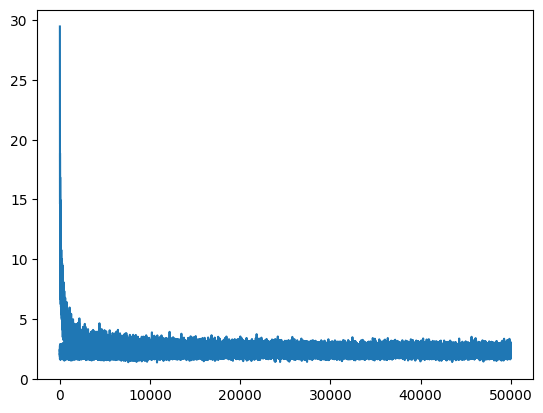

In [39]:
plt.plot(stepi, lossi)

In [40]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1839, grad_fn=<NllLossBackward0>)

In [41]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2236, grad_fn=<NllLossBackward0>)

In [42]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahxamille.
khy.
myli.
thay.
halaysne.
rahnen.
delynn.
jareei.
ner.
keah.
maiivia.
lege.
halm.
pristeniyn.
srocken.
jadiquo.
jero.
dearynix.
kaelynn.
abbed.
